# **Volatility Risk Premium in US Equity Options**

This project investigates the volatility risk premium in US equity options by analysing the relationship between implied and realized volatility across different times to expiration. The analysis focuses on at-the-money call options for the 200 most liquid US stocks over a recent two-year period, examining expirations of 1, 2, 3, and 4 months. Implied volatility was calculated using the Black-Scholes model, while realised volatility was derived from historical price data.

To assess the predictive accuracy of implied volatility, a Heterogeneous Autoregressive (HAR) model was trained using lagged implied volatility features. The project identifies patterns of mispricing and explores how deviations between implied and realised volatility vary across time horizons.

The primary limitation is the restricted two-year dataset, which may not capture long-term trends or volatility behavior across varying market conditions. Nonetheless, the project provides valuable insights into the volatility risk premium and enhances quantitative finance expertise.

We start by connecting to the Polygon API to retrieve a list of all US exchanges. For each exchange, we then gather all available stock tickers and store them in the usTickers list. Finally, we remove duplicates to create a unique list of tickers, saved in the `tickerList` variable


In [1]:
from polygon import RESTClient
from datetime import datetime, timedelta
import pandas as pd

# Initialising the client with my Polygon API key
api_key = "api_key_here"
client = RESTClient(api_key)

# Get all US exchanges
exchanges = pd.DataFrame(client.get_exchanges(asset_class='stocks',
                                              locale='us'))


# Remove duplicates and remove None
exchangeList = list(set(exchanges.mic))
exchangeList.remove(None)


# Getting a list of stock tickers across all US markets
usTickers = []
for x in exchangeList:
    for t in client.list_tickers(market='stocks',
                                    exchange=x,
                                    limit=1000):
        usTickers.append(t.ticker)
            
# final ticker list
tickerList = list(set(usTickers))

With the `tickerList` prepared, we define our analysis date range, covering the past two years—the maximum period available under the current Polygon subscription. For each ticker, we then request aggregate data within this timeframe, capturing key metrics like trading volume. The data is compiled into a dataframe with each ticker and its total volume. Finally, we sort the dataframe in descending order by volume and select the top 200 tickers, which will be the focus of our analysis. We store these final tickers in the `inScopeTickers` variable.

In [2]:
from datetime import datetime

# Define the date range for the analysis.
# Analysis is restricted to the past 2 years, based on my Polygon subscription limits.
start = '2022-11-04'
end = '2024-11-02'
start_date = pd.to_datetime(start).date()
end_date = pd.to_datetime(end).date()
volumeDataFrames = []
for ticker in tickerList:
    try:
        dataRequest = client.get_aggs(ticker = ticker, 
                                    multiplier = (end_date-start_date).days +1,
                                    timespan = 'day',
                                    from_ = start,
                                    to = end)
    except:
        continue
    volumeData = pd.DataFrame(dataRequest)
    if len(volumeData) == 0:
        continue


    volumeData['Ticker'] = ticker
    volumeData = volumeData[['Ticker', 'volume']]
    volumeDataFrames.append(volumeData)

volumeRankings = pd.concat(volumeDataFrames, ignore_index=True).sort_values(by='volume', ascending=False)
inScopeTickers = volumeRankings['Ticker'].to_list()[:200]
volumeRankings.to_csv('volumeRankings.csv')
volumeRankings

,Ticker,volume
6493,NVDA,2.222984e+11
3724,SQQQ,6.731510e+10
7882,TSLA,5.884999e+10
4910,TQQQ,5.154548e+10
2591,SOXL,3.751496e+10
...,...,...
4647,LIAJ,1.600000e+01
4009,LIAF,1.600000e+01
6974,LIAU,1.600000e+01
5091,LIAV,1.400000e+01


With our finalized list of stock tickers, we now request the daily aggregate data for each ticker, focusing primarily on the closing price. In addition, we retrieve a historical record of all stock splits, which will be instrumental in creating a `raw_close` field. This field is crucial for accurately determining the 'at-the-money' option strike prices at specific points in time. After processing each ticker, we compile the information into the `dailyUnderlying` dataframe, which contains both the closing price and the raw close price for every ticker across each trading day within the specified date range. We also calculate the `daily_log_return` field, which represents the daily logarithmic change in the close price. This field is necessay for the calculation of realised volatility.

In [104]:
import numpy as np
dailyPriceDataFrames = []
for ticker in inScopeTickers:
    try:
        # Get the daily aggregate data for each ticker in our population
        dataRequest = client.get_aggs(ticker = ticker, 
                                    multiplier = 1,
                                    timespan = 'day',
                                    from_ = start,
                                    to = end)
    except:
        continue
    dailyPriceData = pd.DataFrame(dataRequest)
    if len(dailyPriceData) == 0:
        continue

    # Rreate Date column
    dailyPriceData['Date'] = dailyPriceData['timestamp'].apply(
                            lambda x: pd.to_datetime(x*1000000).date())
    dailyPriceData['Ticker'] = ticker
    dailyPriceData = dailyPriceData[['Ticker' ,'Date', 'close', 'volume']]

    # Rename the close price to 'close_u' to distinguish the underlying from the option
    dailyPriceData.rename(columns={'close': 'close_u'}, inplace=True)
    dailyPriceData['daily_log_return'] = np.log(dailyPriceData['close_u'] / dailyPriceData['close_u'].shift(1))
    dailyPriceData['Date'] = pd.to_datetime(dailyPriceData['Date'])

    # Load the historical stock splits for the data so that we can get the raw stock price
    splts = []
    for splt in client.list_splits(ticker = ticker):
        splts.append(splt)

    splitsDF = pd.DataFrame.from_records(
        [vars(split) for split in splts]
    )

    if len(splts) == 0:
        dailyPriceData['raw_close'] = dailyPriceData['close_u']
    else:
        splitsDF['split_multiple'] = splitsDF['split_to'] / splitsDF['split_from']

        dailyPriceData['raw_close'] = dailyPriceData['close_u']
        splitsDF['execution_date'] = pd.to_datetime(splitsDF['execution_date'])
        # Iterate over each split and adjust prices
        for _, split in splitsDF.iterrows():
            split_date = split['execution_date']
            split_multiple = split['split_multiple']
            
            # Apply the split adjustment to 'raw_close' for all dates on or before the split date
            dailyPriceData.loc[dailyPriceData['Date'] <= split_date, 'raw_close'] *= split_multiple


    dailyPriceData = dailyPriceData.sort_values(by='Date', ascending=True)

    dailyPriceDataFrames.append(dailyPriceData)

dailyUnderlying = pd.concat(dailyPriceDataFrames, ignore_index=True) 
dailyUnderlying.to_csv('exports/dailyUnderlying.csv')
dailyUnderlying

,Ticker,Date,close_u,volume,raw_close,daily_log_return
0,NVDA,2022-11-04,14.156,612575910.0,141.56,NaN
1,NVDA,2022-11-07,14.301,410060950.0,143.01,0.010191
2,NVDA,2022-11-08,14.602,595291990.0,146.02,0.020829
3,NVDA,2022-11-09,13.776,454299100.0,137.76,-0.058231
4,NVDA,2022-11-10,15.750,700819250.0,157.50,0.133912
...,...,...,...,...,...,...
99673,LUV,2024-10-28,30.300,12915993.0,30.30,0.029133
99674,LUV,2024-10-29,31.030,9329676.0,31.03,0.023807
99675,LUV,2024-10-30,31.470,7284973.0,31.47,0.014080
99676,LUV,2024-10-31,30.580,6424493.0,30.58,-0.028689


Next, we focus on analyzing option contracts with 'standard' expiry dates, which typically occur on the third Friday of each month. However, it’s important to note that some contracts have historically been recorded with expirations on the following Saturday. To ensure we capture all relevant options, we find the intersection of the expiration dates available in the Polygon options data and the standard Friday and Saturday dates for each month within our analysis period. The resulting dates are stored in the `contracts` variable

In [4]:
# Limit the options we ane considering to only those which expire on the third Frdiay 
# (or following Saturday) of the month
trading_days = pd.date_range(start=datetime(2022,10,1), end=datetime(2026,1,1), freq='B')
contracts1 = pd.date_range(start=datetime(2022,10,1), end=datetime(2026,1,1), freq='WOM-3FRI')
contracts2 = pd.date_range(start=datetime(2022,10,1), end=datetime(2026,1,1), freq='WOM-3FRI')+timedelta(days=1)
contracts = contracts1.append(contracts2)

For each ticker in our dataset, we now identify the 'at-the-money' (ATM) call options available for every day. Our focus is on ATM calls with at least 15 days until expiration, spanning four consecutive months, when possible. To optimize our API usage and reduce computation time, we retrieve the list of options as of every Monday within our timeframe. Consequently, the available options for any given date will reflect those generated on the closest prior Monday.

We only include options with a CFI (Classification of Financial Instruments) code of 'OCASPS' or 'OPASPS', which denote standard American options. These classifications were chosen because they represent commonly traded options that provide the necessary liquidity for our analysis.

To determine the ATM call options for each ticker on a given date, we find the strike price closest to the underlying price. If two strikes are equidistant from the underlying price, we select the higher strike. This method allows each ticker/date combination to potentially have up to four relevant ATM options. For instance, if the current date is November 8, 2023, the maximum relevant options would include ATM calls expiring on 15 December 2023; 19 January 2024; 16 February 2024; and 15 March 2024.

All relevant information regarding tickers, dates, and associated ATM call options is compiled into the ``optionContractsData` dataframe.

In [170]:
pd.options.mode.chained_assignment= None
week_starts = pd.date_range(start="2022-10-01", end="2024-11-01", freq='W-MON')
optionContractsDataFrames = []
for ticker in inScopeTickers:
    tickerDF = dailyUnderlying[dailyUnderlying['Ticker'] == ticker]
    optionContracts = []
    optionExpirations = []
    # Limit our API calls to only fetch the option contracts as of the start of each week
    for w in week_starts:
        for c in client.list_options_contracts(underlying_ticker = ticker, limit = 1000, 
                                               as_of=str(w), expiration_date_lt=str((w+ timedelta(days=150)).date())):
            # We filter only for standard contracts which expire in the set of dates described above
            if c.expiration_date in contracts and c.cfi in ['OCASPS','OPASPS']:
                c.addedDate = w
                optionContracts.append(c)
                optionExpirations.append((w, pd.to_datetime(c.expiration_date)))

    optionExpirations = list(set(optionExpirations))

    optionContractsDF = pd.DataFrame.from_records(
        [vars(contract) for contract in optionContracts]
    )
    if len(optionContractsDF) == 0:
        continue

    for index, row in tickerDF.iterrows():

        price = row['raw_close']
        # Our relevant expiry dates are those from the API call at the start of the current week (in the loop)
        recentCallExpiryDates = list(set([e[1] for e in optionExpirations if 
                                          pd.to_datetime(e[0]) == pd.to_datetime(row['Date']) - pd.offsets.Week(weekday=0)]))
        
        # Filter where the expiry dates are between 15 and 150 days from the current date 
        # This will capture those which are 1-4 months away. (1 month expiry here is defined as at least 15 days away)
        filtered_expiry_dates = set(sorted([date for date in recentCallExpiryDates if (date - pd.to_datetime(row['Date'])).days > 15 
                                            and  (date - pd.to_datetime(row['Date'])).days < 150])[:4])            

        filtered_expiry_dates = [str(d.date()) for d in filtered_expiry_dates]

        # We only look at options which were available before the current date in the loop
        recentCallContracts = optionContractsDF[optionContractsDF['addedDate'] <= str(row['Date'].date())]
        filteredExpiryOptionContracts = recentCallContracts[recentCallContracts['expiration_date'].isin(filtered_expiry_dates)]

        # Finding the difference between the strike and the current underling price
        # This will allow us to find the 'at-the-money' options on this date
        filteredExpiryOptionContracts['price_diff'] = (filteredExpiryOptionContracts['strike_price'] - price).abs()

        filteredOptions = (
            filteredExpiryOptionContracts.loc[filteredExpiryOptionContracts.groupby('expiration_date')['price_diff'].idxmin()]  # Get the index of the minimum distance
            .sort_values('strike_price', ascending=False)  # Sort by STRIKE_PRICE in descending order to resolve ties
            .drop_duplicates('expiration_date')  # Keep only the highest STRIKE_PRICE for ties
        )

        filteredOptions['Date'] = row['Date']  
        filteredOptions['Ticker'] = ticker  
        # Save our list of at-the-money options for this underlying ticker, on this date
        optionContractsDataFrames.append(filteredOptions)


optionContractsData = pd.concat(optionContractsDataFrames, ignore_index=True) 
optionContractsData.to_csv('exports/optionContractsData.csv')
optionContractsData

,additional_underlyings,cfi,contract_type,correction,exercise_style,expiration_date,primary_exchange,shares_per_contract,strike_price,ticker,underlying_ticker,addedDate,price_diff,Date,Ticker
0,None,OCASPS,call,None,american,2023-01-20,BATO,100,142.5,O:NVDA230120C00142500,NVDA,2022-10-03,0.94,2022-11-04,NVDA
1,None,OCASPS,call,None,american,2022-12-16,BATO,100,140.0,O:NVDA221216C00140000,NVDA,2022-10-03,1.56,2022-11-04,NVDA
2,None,OCASPS,call,None,american,2023-02-17,BATO,100,140.0,O:NVDA230217C00140000,NVDA,2022-10-03,1.56,2022-11-04,NVDA
3,None,OCASPS,call,None,american,2023-03-17,BATO,100,140.0,O:NVDA230317C00140000,NVDA,2022-10-24,1.56,2022-11-04,NVDA
4,None,OCASPS,call,None,american,2022-12-16,BATO,100,145.0,O:NVDA221216C00145000,NVDA,2022-10-03,1.99,2022-11-07,NVDA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309048,None,OCASPS,call,None,american,2025-01-17,BATO,100,30.0,O:LUV250117C00030000,LUV,2024-08-26,0.58,2024-10-31,LUV
309049,None,OCASPS,call,None,american,2025-03-21,BATO,100,30.0,O:LUV250321C00030000,LUV,2024-10-28,0.58,2024-10-31,LUV
309050,None,OCASPS,call,None,american,2024-12-20,BATO,100,30.0,O:LUV241220C00030000,LUV,2024-07-29,0.61,2024-11-01,LUV
309051,None,OCASPS,call,None,american,2025-01-17,BATO,100,30.0,O:LUV250117C00030000,LUV,2024-08-26,0.61,2024-11-01,LUV


With our list of option contract tickers established for each underlying ticker and date, we now need to acquire the daily aggregate trade data for these options. This data is crucial for obtaining the closing prices required for calculating implied volatility. It is important to note that API calls for historical aggregates of option data must be made one ticker at a time.

To efficiently gather this information, we loop through each ticker stored in the `optionContractsData` dataframe. For every ticker, we identify the specific days when it is designated as the ATM call option. We then collect relevant contract data—including underlying ticker, strike price, expiration date, and shares per contract—and merge this with the daily aggregate trade data. This consolidated information for each option ticker is stored in the `optionTradeInfoData` dataframe

In [173]:
# Loop trough each option contract to find the daily aggregates. 
optionTradeInfoDataFrames = []
for contract_ticker in set(optionContractsData['ticker'].to_list()):
    # Find the set of dates which we need the options price
    dates = set(optionContractsData[optionContractsData['ticker'] == contract_ticker]['Date'].to_list())
    dates = [d.date() for d in dates]
    # Extract the contract details
    expiration_date = optionContractsData.loc[optionContractsData['ticker'] == contract_ticker, 'expiration_date'].iloc[0]
    strike_price = optionContractsData.loc[optionContractsData['ticker'] == contract_ticker, 'strike_price'].iloc[0]
    contract_type = optionContractsData.loc[optionContractsData['ticker'] == contract_ticker, 'contract_type'].iloc[0]
    underlying_ticker = optionContractsData.loc[optionContractsData['ticker'] == contract_ticker, 'underlying_ticker'].iloc[0]
    shares_per_contract = optionContractsData.loc[optionContractsData['ticker'] == contract_ticker, 'shares_per_contract'].iloc[0]
    try:
        dataRequest = client.get_aggs(ticker = contract_ticker, 
                                multiplier = 1,
                                timespan = 'day',
                                from_ = str(min(dates)),
                                to = str(max(dates)))      
    except:
        continue

    optionData = pd.DataFrame(dataRequest)    
    if len(optionData) ==0:
        continue

    optionData['Date'] = optionData['timestamp'].apply(
                            lambda x: pd.to_datetime(x*1000000))
    optionData = optionData.set_index('Date')

    optionData['Date'] = optionData['timestamp'].apply(
                          lambda x: pd.to_datetime(x*1000000).date())
    
    # Filter the trade data for only the relevant dates
    optionData = optionData[optionData['Date'].isin(dates)]
    
    # Add the contract details to the daily aggregate data
    optionData['ticker'] = contract_ticker
    optionData['expiration_date'] = expiration_date
    optionData['strike_price'] = strike_price
    optionData['contract_type'] = contract_type
    optionData['underlying_ticker'] = underlying_ticker
    optionData['shares_per_contract'] = shares_per_contract
    optionTradeInfoDataFrames.append(optionData)

optionTradeInfoData = pd.concat(optionTradeInfoDataFrames, ignore_index=True) 

optionTradeInfoData = optionTradeInfoData[['Date', 'underlying_ticker', 'ticker', 'close', 'expiration_date', 
                                           'strike_price', 'contract_type', 'shares_per_contract']]
optionTradeInfoData.rename(columns={'close': 'close_o'}, inplace=True)

optionTradeInfoData['Date'] = pd.to_datetime(optionTradeInfoData['Date'])
optionTradeInfoData['expiration_date'] = pd.to_datetime(optionTradeInfoData['expiration_date'])

# Calculate the day difference between expiration_date and Date
optionTradeInfoData['day_difference'] = (optionTradeInfoData['expiration_date'] - optionTradeInfoData['Date']).dt.days

# Define the thresholds for the expiration months
thresholds = {30: 1, 60: 2, 90: 3, 120: 4}

# Function to find the closest month number based on day difference
def assign_expiration_month(day_diff):
    closest_days = min(thresholds.keys(), key=lambda x: abs(x - day_diff))
    return thresholds[closest_days]

# Apply the function to assign the expiration month
optionTradeInfoData['expiration_month'] = optionTradeInfoData['day_difference'].apply(assign_expiration_month)

# Drop the helper column if not needed
optionTradeInfoData = optionTradeInfoData.drop(columns='day_difference')
optionTradeInfoData = optionTradeInfoData.sort_values(['underlying_ticker','Date', 'expiration_date'])
optionTradeInfoData.to_csv('exports/optionTradeInfoData.csv')
optionTradeInfoData

,Date,underlying_ticker,ticker,close_o,expiration_date,strike_price,contract_type,shares_per_contract,expiration_month
162856,2022-11-07,AAL,O:AAL221216C00014000,1.14,2022-12-16,14.0,call,100,1
8331,2022-11-07,AAL,O:AAL230120C00014000,1.57,2023-01-20,14.0,call,100,2
231493,2022-11-07,AAL,O:AAL230217C00014000,1.70,2023-02-17,14.0,call,100,3
162857,2022-11-08,AAL,O:AAL221216C00014000,1.11,2022-12-16,14.0,call,100,1
8332,2022-11-08,AAL,O:AAL230120C00014000,1.54,2023-01-20,14.0,call,100,2
...,...,...,...,...,...,...,...,...,...
226066,2024-10-30,YANG,O:YANG250117C00004000,0.45,2025-01-17,4.0,call,100,3
70471,2024-10-31,YANG,O:YANG241220C00004000,0.45,2024-12-20,4.0,call,100,2
226067,2024-10-31,YANG,O:YANG250117C00004000,0.50,2025-01-17,4.0,call,100,3
70472,2024-11-01,YANG,O:YANG241220C00004000,0.40,2024-12-20,4.0,call,100,2


In this section, we utilize the `yfinance` library to create a DataFrame containing the 3-month Treasury yields for each day within our specified date range. These Treasury yields serve as a proxy for the risk-free rate, which is a critical component in our implied volatility calculations. We will be storing this data in the `rates_df` variable.

The 3-month Treasury yield is widely used in financial markets to represent the risk-free rate of return, as it reflects the return on government debt securities with a short-term maturity. By incorporating these yields into our analysis, we ensure that our implied volatility calculations are grounded in accurate market conditions.


In [20]:
import yfinance as yf
import warnings
warnings.simplefilter("ignore", FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Define start and end dates for the range
start_date = '2022-11-01'
end_date = '2024-11-03'

# Generate a DataFrame with a daily date range
dates_df = pd.DataFrame({"Date": pd.date_range(start=start_date, end=end_date, freq='D')})
dates_df['Date'] = pd.to_datetime(dates_df['Date'])
# Fetch the 3-month Treasury yield data from Yahoo Finance using "^IRX"
try:
    t_bill_data = yf.download("^IRX", start=start_date, end=end_date, interval="1d", progress=False )['Close']

    # Rename column to '3 Month Risk-Free Rate' and adjust to a percentage (assuming basis points)
    t_bill_data = t_bill_data.reset_index()
    t_bill_data['Date'] = pd.to_datetime(t_bill_data['Date']).dt.tz_localize(None)
    t_bill_data.rename(columns={'^IRX': 'Risk Free Rate'}, inplace=True)
    rates_df = dates_df.merge(t_bill_data, left_on='Date', right_on='Date', how='left')
    rates_df['Risk Free Rate'] = rates_df['Risk Free Rate'].fillna(method='ffill')
except Exception as e:
    print("Error fetching data from yfinance:", e)


To facilitate our implied volatility calculations, we need to consolidate all relevant data points into a single DataFrame. This requires joining three key DataFrames: 

1. **`dailyUnderlying`** - This DataFrame contains the close prices of the underlying stocks.
2. **`optionTradeInfoData`** - This DataFrame includes the close prices and contract details for the options.
3. **`rates_df`** - This DataFrame holds the risk-free rates obtained from the Treasury yields.

By merging these DataFrames, we ensure that each row in our final table contains all necessary information, allowing for straightforward calculations of implied volatility. 

In [26]:
dailyUnderlying['Date'] = pd.to_datetime(dailyUnderlying['Date'])
optionTradeInfoData['Date'] = pd.to_datetime(optionTradeInfoData['Date'])

underlyingOptionJoinDF = pd.merge(
    dailyUnderlying,
    optionTradeInfoData,
    how='left',  # Left join
    left_on=['Date', 'Ticker'],  
    right_on=['Date', 'underlying_ticker']  
)

underlyingOptionJoinDF = underlyingOptionJoinDF.merge(rates_df, left_on='Date', right_on='Date', how='left')
underlyingOptionJoinDF

,Ticker,Date,close_u,volume,raw_close,daily_log_return,underlying_ticker,ticker,close_o,expiration_date,strike_price,contract_type,shares_per_contract,expiration_month,Risk Free Rate
0,NVDA,2022-11-04,14.156,612575910.0,141.56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.013
1,NVDA,2022-11-07,14.301,410060950.0,143.01,0.010191,NVDA,O:NVDA221216C00145000,10.65,2022-12-16,145.0,call,100.0,1.0,3.983
2,NVDA,2022-11-07,14.301,410060950.0,143.01,0.010191,NVDA,O:NVDA230120C00142500,15.40,2023-01-20,142.5,call,100.0,2.0,3.983
3,NVDA,2022-11-07,14.301,410060950.0,143.01,0.010191,NVDA,O:NVDA230217C00145000,17.25,2023-02-17,145.0,call,100.0,3.0,3.983
4,NVDA,2022-11-07,14.301,410060950.0,143.01,0.010191,NVDA,O:NVDA230317C00145000,19.21,2023-03-17,145.0,call,100.0,4.0,3.983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284222,LUV,2024-10-31,30.580,6424493.0,30.58,-0.028689,LUV,O:LUV250117C00030000,2.53,2025-01-17,30.0,call,100.0,3.0,4.432
284223,LUV,2024-10-31,30.580,6424493.0,30.58,-0.028689,LUV,O:LUV250321C00030000,3.45,2025-03-21,30.0,call,100.0,4.0,4.432
284224,LUV,2024-11-01,30.610,5883239.0,30.61,0.000981,LUV,O:LUV241220C00030000,1.93,2024-12-20,30.0,call,100.0,2.0,4.400
284225,LUV,2024-11-01,30.610,5883239.0,30.61,0.000981,LUV,O:LUV250117C00030000,2.37,2025-01-17,30.0,call,100.0,3.0,4.400


In this step, we define the functions required for calculating implied volatility, starting with the Black-Scholes pricing formula for options. The Black-Scholes model is a mathematical model that calculates the theoretical price of European-style options based on several key factors, including the current stock price, strike price, time to expiration, risk-free interest rate, and the volatility of the underlying asset.

The formula for the price of a call option is given by:

$$ C = S N(d_1) - K e^{-rT} N(d_2) $$


And for a put option:

$$ P = K e^{-rT} N(-d_2) - S N(-d_1) $$

Where:

- $ C $ = Call option price
- $ P $ = Put option price
- $ S $ = Current stock price
- $ K $ = Strike price
- $ T $ = Time to expiration (in years)
- $ r $ = Risk-free interest rate
- $ \sigma $ = Volatility of the underlying asset
- $ N(d) $ = Cumulative distribution function of the standard normal distribution

In our implementation, the function `black_scholes_price` takes the following parameters: the current stock price $ S $, the strike price $ K $, the time to expiration $ T $, the risk-free interest rate $ r $, the volatility $ \sigma $, and the option type (either 'call' or 'put'). 

Inside the function, we first calculate $ d_1 $ and $ d_2 $:

$$ d_1 = \frac{\ln(S / K) + (r + 0.5 \sigma^2) T}{\sigma \sqrt{T}} $$
$$ d_2 = d_1 - \sigma \sqrt{T} $$

Based on the option type specified, the function calculates and returns the appropriate option price. This foundational function will be integral in computing the implied volatility of the options we analyze.

***Note on Option Type:***  *Although the options analyzed in this study are American-style, which can be exercised at any time before expiration, we justify the use of the Black-Scholes pricing model due to the requirement for a minimum of 15 days until expiration for the options selected. This relatively long time frame allows for the assumption of a continuous price path, making the Black-Scholes model a suitable approximation for these options. Furthermore, since the options will not be exercised until close to expiration, the value calculated using the Black-Scholes model provides a reasonable estimate of the option's price under typical market conditions.*


In [176]:
import numpy as np
import pandas as pd
from scipy.optimize import brentq
from scipy.stats import norm

# Black-Scholes model for option pricing
def black_scholes_price(S, K, T, r, sigma, option_type):
    """Calculate the Black-Scholes price for a call or put option."""
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option_type.lower() == 'call':
        price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type.lower() == 'put':
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        raise ValueError("option_type must be either 'call' or 'put'")
        
    return price


The next function utilizes the `black_scholes_price` function defined above and applies the Brent method to calculate the implied volatility of an option.

The **Brent method** is a root-finding algorithm that combines the bisection method, the secant method, and inverse quadratic interpolation. This method is particularly advantageous for finding roots of a function due to its robustness and efficiency. It converges faster than bisection and is more reliable than pure secant methods, especially when dealing with functions that may have discontinuities or flat regions.

To calculate the implied volatility, we need to find the volatility $\sigma$ that equates the theoretical price from the Black-Scholes model to the market price of the option. This can be expressed mathematically as:

$$ f(\sigma) = C(S, K, T, r, \sigma) - P_{\text{market}} = 0 $$

where $C(S, K, T, r, \sigma)$ is the Black-Scholes price of the option, and $P_{\text{market}}$ is the observed market price. The goal is to solve for $\sigma$ such that $f(\sigma) = 0$.

Since the Black-Scholes model provides a closed-form solution for the option price given known parameters, it does not yield a direct solution for volatility; thus, we must use a numerical approach. This is because the relationship between volatility and option price is not linear, and different volatility values can lead to the same option price, making it a non-trivial problem. Therefore, root-finding algorithms, like the Brent method, are essential for iteratively solving for the implied volatility that matches the observed market price.

In [ ]:
# Implied volatility calculation
def implied_volatility(S, K, T, r, market_price, option_type):
    """Calculate the implied volatility using a numerical solver."""
    try:
        # Define a function whose root (solution) will give us the implied volatility
        implied_vol_func = lambda sigma: black_scholes_price(S, K, T, r, sigma, option_type) - market_price
        
        # Use brentq solver to find the root within a reasonable range for volatility
        return brentq(implied_vol_func,-1e-20,100,maxiter=1000)  # Limits set to ensure solution stability
    except ValueError as e:

        return np.nan  # Return NaN if no solution is found

Finally, we will define the `add_implied_volatility` function, which will take a DataFrame as input. This function will utilize the previously defined `black_scholes_price` and `implied_volatility` functions to calculate the implied volatility for each option contract in the DataFrame. 

The `add_implied_volatility` function will iterate through each row of the DataFrame, extracting the necessary parameters such as the underlying asset price, strike price, time to expiration, risk-free rate, and market price of the option. It will then apply the `implied_volatility` function to compute the implied volatility, which will be added as a new field to the DataFrame. 


In [ ]:
# Main function to add implied volatility to the DataFrame
def add_implied_volatility(df):
    """Add an 'implied_volatility' column to the DataFrame."""
    iv_values = []
    
    for _, row in df.iterrows():
        if str(row['close_o']) == 'nan':
            iv_values.append(np.nan)
            continue
        S = row['raw_close']
        K = row['strike_price']
        T = (pd.to_datetime(row['expiration_date']).date() - row['Date'].date()).days / 365  # Time to expiration in years
        r = row['Risk Free Rate']  / 100
        market_price = row['close_o'] 
        option_type = row['contract_type']
        
        # Calculate implied volatility
        iv = implied_volatility(S, K, T, r, market_price, option_type)
        iv_values.append(iv)
    
    # Add new column to the DataFrame
    df['implied_volatility'] = iv_values
    return df

In this section, we define a function to calculate the realised volatility of the underlying asset. Realised volatility is a statistical measure that captures the degree of variation in the returns of an asset over a specific period. It is typically computed using historical price data and is crucial for understanding the asset's past price movements.

Realised volatility is often calculated as the standard deviation of the asset's **log returns** over a given time period. The formula for realized volatility ($ \sigma_{\text{realized}} $) can be expressed as:

$$
\sigma_{\text{realized}} = \sqrt{\frac{1}{N} \sum_{i=1}^{N} (R_i - \bar{R})^2}
$$

Where:
- $ N $ is the number of observations (daily log returns in this case).
- $ R_i $ is the log return on day $ i $.
- $ \bar{R} $ is the mean log return over the sample period.

To annualize the realized volatility, we multiply it by the square root of the number of trading days in a year (commonly assumed to be 252):

$$
\sigma_{\text{annualized}} = \sigma_{\text{realized}} \times \sqrt{252}
$$

The `calculate_realised_volatility` function works as follows:

1. It takes a row of data and the entire DataFrame as input.
2. It defines the start date as the day after the option pricing date and the end date as the expiration date of the option.
3. It filters the DataFrame to obtain **log returns** for the underlying asset within the specified date range.
4. If there are returns available in the filtered range, it calculates the realized volatility as the standard deviation of these log returns, annualized by multiplying by $ \sqrt{252} $.
5. If there are no returns available, it returns `NaN`.


In [89]:
def calculate_realised_volatility(row, df):
    start_date = row['Date'] + pd.Timedelta(days=1)  # Day after the option pricing date
    end_date = pd.to_datetime(row['expiration_date'])
    underlying_ticker = row['underlying_ticker']
    if str(end_date) == 'nan':
        return
    if end_date not in df['Date'].values:
        return 
    # Filter daily returns for the specified date range
    filtered_records = df[(df['Date'] >= start_date) & (df['Date'] <= end_date) & (df['Ticker'] == underlying_ticker)]
    df = filtered_records[['Ticker', 'Date', 'daily_log_return']]
    unique_df = df.drop_duplicates(subset=['Ticker', 'Date', 'daily_log_return'])
    returns_in_range = unique_df['daily_log_return']

    # Calculate realised volatility if there are returns in the range
    if not returns_in_range.empty:
        realised_vol = np.std(returns_in_range) * np.sqrt(252)  # Annualizing based on trading days
        return realised_vol
    else:
        return np.nan

In this section, we apply the functions defined above to our `underlyingOptionJoinDF` DataFrame to create the 'implied_volatility' and 'realised_volatility' fields. 

Implied volatility (IV) is often viewed as the market's forecast of the asset's expected volatility over the life of the option. It is derived from the market price of options and reflects the consensus of market participants regarding future price movements. By contrast, realised volatility (RV) is a historical measure that quantifies the actual volatility experienced by the underlying asset over a specific period.

By calculating realised volatility looking 'forward' in time, we can assess how accurate the market's estimates (represented by implied volatility) were over the life of the option. When there are significant discrepancies between implied and realised volatility, it may indicate that certain securities are mispriced. Traders often look for these discrepancies to identify potential trading opportunities.

For instance, if a trader predicts that the realised volatility will differ significantly from the implied volatility (either higher or lower), they can implement strategies to profit from this mispricing. If the trader believes that the implied volatility is too high compared to their forecast for realised volatility, they might sell options (a strategy known as "selling volatility"). Conversely, if the trader expects that the implied volatility is too low, they might buy options (a strategy known as "buying volatility"). 

If the trader's prediction is correct and the actual realised volatility diverges from the implied volatility, they stand to gain from their position. The profitability arises from the fact that the option prices will adjust to reflect the realised volatility, providing an opportunity for the trader to capitalize on the market's previous misestimation. Thus, understanding and analysing the relationship between implied and realised volatility can be a powerful tool in a trader's strategy.

In [105]:
underlyingOptionJoinDF = add_implied_volatility(underlyingOptionJoinDF)
underlyingOptionJoinDF['realised_volatility'] = underlyingOptionJoinDF.apply(calculate_realised_volatility, axis=1,  args=(underlyingOptionJoinDF,))
underlyingOptionJoinDF.to_csv('exports/underlyingOptionJoinDF.csv')
underlyingOptionJoinDF

,Ticker,Date,close_u,volume,daily_log_return,raw_close,underlying_ticker,ticker,close_o,expiration_date,strike_price,contract_type,shares_per_contract,expiration_month,Risk Free Rate,implied_volatility,realised_volatility
0,NVDA,2022-11-04,14.156,612575910.0,0.000000,141.56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.013,NaN,NaN
1,NVDA,2022-11-07,14.301,410060950.0,0.010191,143.01,NVDA,O:NVDA221216C00145000,10.65,2022-12-16,145.0,call,100.0,1.0,3.983,0.605287,0.648328
2,NVDA,2022-11-07,14.301,410060950.0,0.010191,143.01,NVDA,O:NVDA230120C00142500,15.40,2023-01-20,142.5,call,100.0,2.0,3.983,0.571543,0.620067
3,NVDA,2022-11-07,14.301,410060950.0,0.010191,143.01,NVDA,O:NVDA230217C00145000,17.25,2023-02-17,145.0,call,100.0,3.0,3.983,0.579796,0.609287
4,NVDA,2022-11-07,14.301,410060950.0,0.010191,143.01,NVDA,O:NVDA230317C00145000,19.21,2023-03-17,145.0,call,100.0,4.0,3.983,0.566205,0.607938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284222,LUV,2024-10-31,30.580,6424493.0,-0.028689,30.58,LUV,O:LUV250117C00030000,2.53,2025-01-17,30.0,call,100.0,3.0,4.432,0.372795,NaN
284223,LUV,2024-10-31,30.580,6424493.0,-0.028689,30.58,LUV,O:LUV250321C00030000,3.45,2025-03-21,30.0,call,100.0,4.0,4.432,0.386684,NaN
284224,LUV,2024-11-01,30.610,5883239.0,0.000981,30.61,LUV,O:LUV241220C00030000,1.93,2024-12-20,30.0,call,100.0,2.0,4.400,0.340766,NaN
284225,LUV,2024-11-01,30.610,5883239.0,0.000981,30.61,LUV,O:LUV250117C00030000,2.37,2025-01-17,30.0,call,100.0,3.0,4.400,0.342923,NaN


## Analysis

Now that we have collected and processed all of our data, we are ready to begin our analysis. Our first objective is to identify securities that consistently exhibit signs of mispricing. To do this, we will calculate the absolute difference between implied volatility (IV) and realised volatility (RV) over the same time period for each security. This difference gives us an indicator of how much the market's volatility expectations (IV) deviate from actual outcomes (RV), serving as a proxy for potential mispricing.

To gain deeper insights, we will partition these absolute differences by expiration month and visualise the top 10 securities with the highest mean daily absolute difference in horizontal bar graphs for each expiration date. This approach allows us to observe patterns across different maturities, providing a clearer picture of which securities tend to have consistently high deviations in volatility expectations.

As the graphs illustrate, certain securities appear repeatedly across the expiration dates, suggesting persistent mispricing in the at-the-money (ATM) calls. This consistent mispricing is valuable information for traders, as it points to securities where volatility has been challenging to predict accurately. By focusing on these securities, traders who can forecast volatility more precisely than the market may find potential trading opportunities.

In this analysis, we observed that the top mispriced securities across each of the expiration dates were **TeraWulf Inc. (WULF)**, **GameStop Corp. (GME)**, **AMC Entertainment Holdings Inc. (AMC)**, **SoundHound AI Inc. (SOUN)**, and **Bitfarms Ltd (BITF)**. The repeated appearance of these securities in the rankings underscores their potential for volatility-based trading strategies, especially for those able to anticipate future volatility trends more accurately than the broader market.

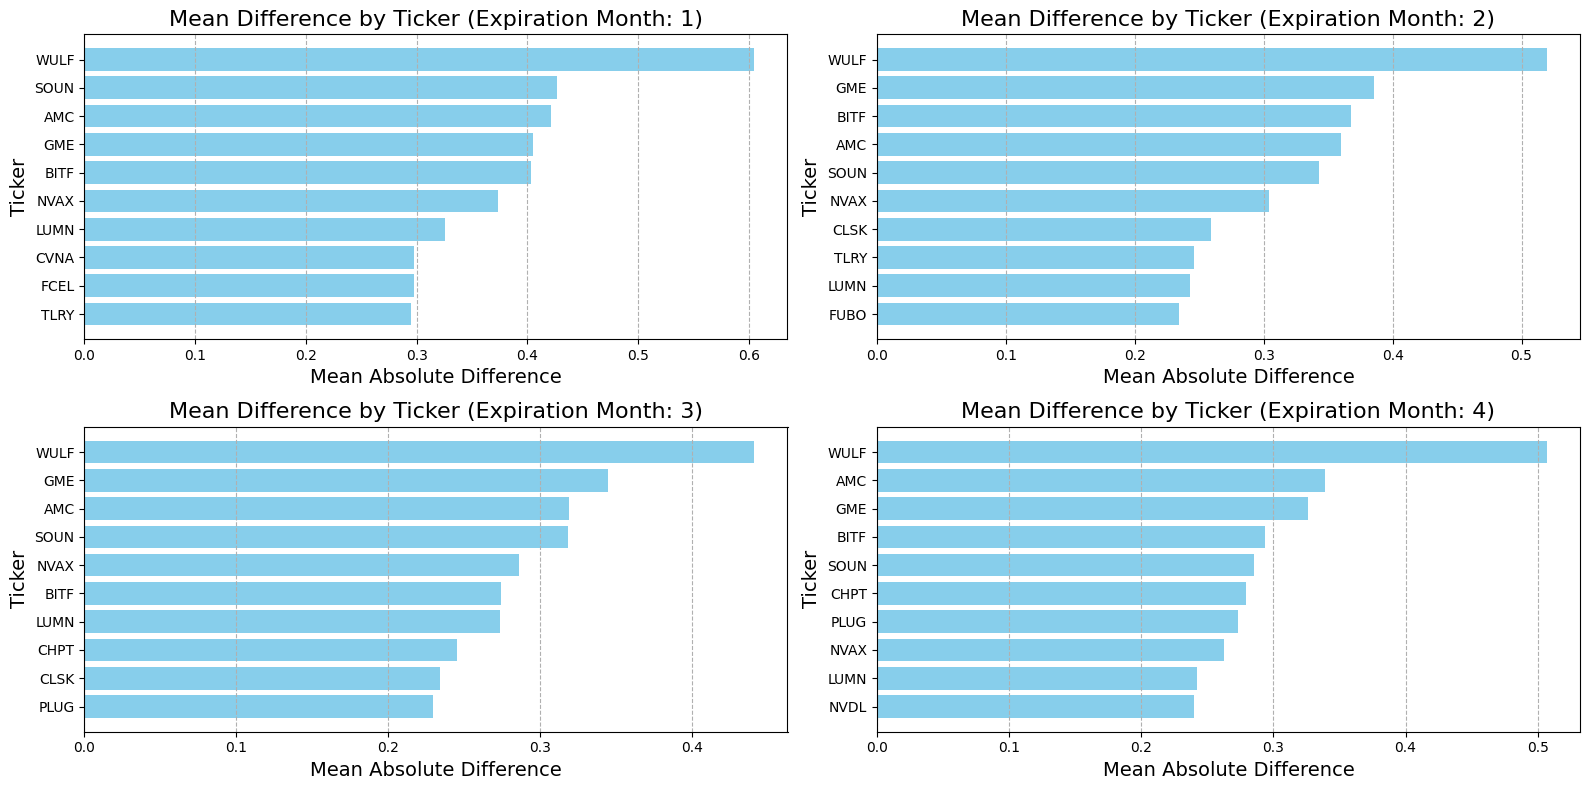

In [107]:
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None 

analysis_df = underlyingOptionJoinDF.dropna(subset=['implied_volatility', 'realised_volatility'])
analysis_df['vol_abs_diff'] = abs(analysis_df['implied_volatility'] - analysis_df['realised_volatility'])
analysis_df['vol_diff'] = analysis_df['implied_volatility'] - analysis_df['realised_volatility']
mean_difference_df = analysis_df.groupby(['Ticker', 'expiration_month'], as_index=False).agg(
    mean_abs_difference=('vol_abs_diff', 'mean'))

fig, axes = plt.subplots(2, 2, figsize=(16, 8))
expiration_months = [1, 2, 3, 4] 

for i, expiration_month in enumerate(expiration_months):
    # Filter data for the specific expiration month
    filtered_df = mean_difference_df[mean_difference_df['expiration_month'] == expiration_month]
    
    # Get top 10 tickers with the highest mean absolute difference
    top_10_df = filtered_df.nlargest(10, 'mean_abs_difference')
    
    # Plot on the respective subplot in the 2x2 grid
    ax = axes[i // 2, i % 2]  # Determines row and column index for each plot
    ax.barh(top_10_df['Ticker'], top_10_df['mean_abs_difference'], color='skyblue')
    ax.invert_yaxis()
    # Set title and labels for each subplot
    ax.set_title(f'Mean Difference by Ticker (Expiration Month: {expiration_month})', fontsize=16)
    ax.set_xlabel('Mean Absolute Difference', fontsize=14)
    ax.set_ylabel('Ticker', fontsize=14)
    ax.grid(axis='x', linestyle='--')

# Adjust layout for spacing
plt.tight_layout()
plt.show()

In this section, we plot the time series of the differences between implied and realised volatility for each of the four expiration months. This visualisation allows us to observe how the volatility forecasted by the market (implied volatility) compares with the actual volatility observed (realised volatility) over the life of these options.

#### Key Observations:

1. **Volatility Risk Premium**:
   One of the most striking features in these time series is that the differences are predominantly above zero. This means that implied volatility generally exceeds realised volatility for the majority of the observed period, with the largest discrepancies also tending to be positive. This persistent gap is widely recognized in the industry as the **volatility risk premium**. 

   Researchers suggest that the volatility premium exists due to investor preferences and market behaviors. Many investors, particularly those wary of negative returns and high volatility in equity markets, are willing to pay a premium for portfolio protection, such as purchasing options, especially puts. This demand for protection drives up implied volatility relative to realised volatility. Another potential explanation for the premium is the **Peso problem**—a scenario in which markets price in a rare, impactful event that doesn’t occur in the sample. However, it’s unlikely that this alone accounts for the volatility premium, as research indicates that large market crashes would need to happen relatively frequently to neutralize this premium consistently.

2. **Increased Volatility Discrepancies Closer to Expiration**:
   Another notable observation is that the 1-month expiration series (the closest to expiration) often exhibits the greatest volatility discrepancies, both positive and negative. This pattern suggests that options become increasingly challenging to price as they near their expiration, potentially due to factors like changing market sentiment or higher sensitivity to price movements,.

This analysis of implied versus realised volatility can provide valuable insights for traders. By understanding the volatility risk premium and the behavior of volatility differences near expiration, they can refine their strategies. For instance, if a trader anticipates that the market has overestimated future volatility (high implied volatility relative to expected realised volatility), they could potentially profit by selling options, capitalizing on this premium.

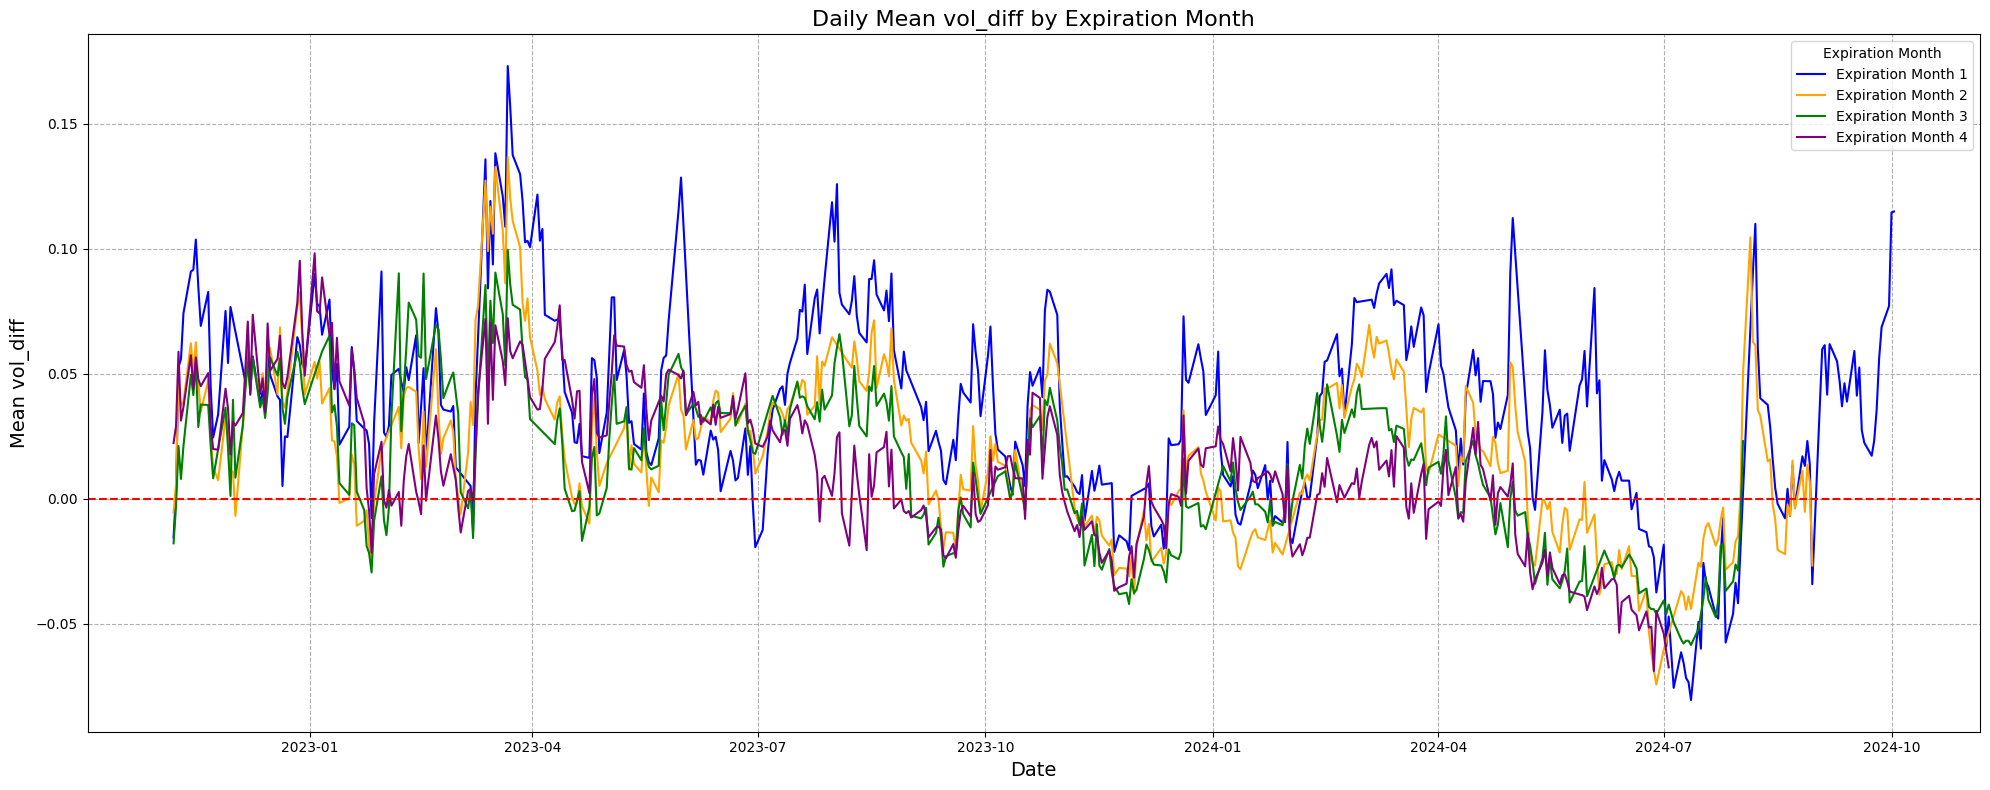

In [93]:
# Calculate the daily mean of vol_diff for each expiration month
daily_mean_df = analysis_df.groupby(['Date', 'expiration_month'], as_index=False).agg(
    mean_vol_diff=('vol_diff', 'mean')
)

# Set up the plot
plt.figure(figsize=(20, 8))

# Plot each expiration month on the same axes with different colors
expiration_months = [1, 2, 3, 4]
colors = ['blue', 'orange', 'green', 'purple']
for expiration_month, color in zip(expiration_months, colors):
    # Filter data for the specific expiration month
    monthly_data = daily_mean_df[daily_mean_df['expiration_month'] == expiration_month]
    
    # Plot the time series for this expiration month
    plt.plot(monthly_data['Date'], monthly_data['mean_vol_diff'], label=f'Expiration Month {expiration_month}', color=color)
# Add a horizontal line at y=0
plt.axhline(0, color='red', linestyle='--', linewidth=1.5)
# Set the title and labels
plt.title('Daily Mean vol_diff by Expiration Month', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Mean vol_diff', fontsize=14)

# Add a legend to differentiate expiration months
plt.legend(title='Expiration Month')

# Display the grid
plt.grid(True, linestyle='--')

# Show the plot
plt.tight_layout()
plt.show()

### Training a Heterogeneous Autoregressive (HAR) Model for Realised Volatility Prediction

In this phase, we aim to train a **Heterogeneous Autoregressive (HAR) model** to predict the implied volatility for options with 1-month expiration. By comparing these predictions with the actual market-implied volatility for the same options, we can evaluate whether the HAR model offers an improvement over simple market forecasts.

#### Understanding the Heterogeneous Autoregressive (HAR) Framework

The **Heterogeneous Autoregressive (HAR) model** is a time series model designed to forecast volatility based on multiple time horizons. Unlike simple autoregressive (AR) models, the HAR model uses different lagged features to capture both short-term and long-term dependencies in the volatility series. 

In this case, we are using **implied volatility** for options with 1, 2, 3, and 4 months to expiration as the features. The model will incorporate lagged values for each expiration horizon.

The HAR model can be represented by the following equation:

$$ 
IV_{t}^{1} = \beta_0 + \beta_1 IV_{t-1}^{1} + \beta_2 \left(\frac{1}{5} \sum_{j=1}^5 IV_{t-j}^{1}\right) + \beta_3 \left(\frac{1}{22} \sum_{j=1}^{22} IV_{t-j}^{1}\right) + \dots + \beta_{10} IV_{t-1}^{4} + \beta_{11} \left(\frac{1}{5} \sum_{j=1}^5 IV_{t-j}^{4}\right) + \beta_{12} \left(\frac{1}{22} \sum_{j=1}^{22} IV_{t-j}^{4}\right) + \epsilon_t
$$

Where:
- $ IV_{t}^{1}, IV_{t}^{2}, IV_{t}^{3}, IV_{t}^{4} $ are the implied volatilities at time $ t $ for the 1-month, 2-month, 3-month, and 4-month expiration options, respectively,

- $ IV_{t-1}^{1}, IV_{t-1}^{2}, IV_{t-1}^{3}, IV_{t-1}^{4} $ are the lagged implied volatilities from the previous day for each expiration month,

- $ \frac{1}{5} \sum_{j=1}^5 IV_{t-j}^{1}, \frac{1}{5} \sum_{j=1}^5 IV_{t-j}^{2}, \frac{1}{5} \sum_{j=1}^5 IV_{t-j}^{3}, \frac{1}{5} \sum_{j=1}^5 IV_{t-j}^{4} $ are the 5-day rolling averages for each expiration month,

- $ \frac{1}{22} \sum_{j=1}^{22} IV_{t-j}^{1}, \frac{1}{22} \sum_{j=1}^{22} IV_{t-j}^{2}, \frac{1}{22} \sum_{j=1}^{22} IV_{t-j}^{3}, \frac{1}{22} \sum_{j=1}^{22} IV_{t-j}^{4} $ are the 22-day rolling averages for each expiration month,

- $ \beta_1, \beta_2, \dots, \beta_{12} $ are the coefficients of the model, representing the impact of each feature (lagged implied volatilities and rolling averages).

- $ \epsilon_t $ is the error term.

In this updated version of the HAR model, each expiration month (1-month, 2-month, 3-month, and 4-month) has its own lag structure, with three different types of lags (1-day, 5-day, and 22-day) included as features.

#### Structuring the Dataset for HAR Model Training

To apply the HAR framework to predict implied volatility, we need to prepare our dataset as follows:

1. **Pivoting the Data**:
   First, we pivot the `underlyingOptionJoinDF` dataframe so that each row corresponds to a unique ticker-date combination, with four columns for implied volatility (one for each expiration month). This provides a clean dataset where we can extract lagged features of implied volatility.

2. **Creating Lagged Features**:
   For each expiration month’s implied volatility, we calculate:
   - The prior day’s implied volatility value,
   - The rolling 5-day average of implied volatility,
   - The rolling 22-day average of implied volatility.

   By doing this for each of the four implied volatility columns (1-month, 2-month, 3-month, and 4-month), we generate a total of **12 features** to train the model.

The resulting dataset, `underlyingOptionJoinDF_pivoted`, is now structured to capture multi-horizon volatility dynamics, making it an ideal input for the HAR model. By training the HAR model on this data, we can compare the predicted implied volatility values against the actual market-implied volatility, identifying any potential inefficiencies or patterns in the market’s pricing of options.


In [102]:
underlyingOptionJoinDF['daily_log_return'] = underlyingOptionJoinDF['daily_log_return'].fillna(0)
underlyingOptionJoinDF_pivoted = underlyingOptionJoinDF.pivot_table(
    index=['Date','Ticker', 'close_u', 'volume', 'daily_log_return', 'raw_close', 'underlying_ticker', 'contract_type', 'shares_per_contract', 'Risk Free Rate'],
    columns='expiration_month',
    aggfunc='first'
).reset_index()

underlyingOptionJoinDF_pivoted.columns = [f'{col}_month_{int(month)}' if month != '' else col for col, month in underlyingOptionJoinDF_pivoted.columns]

implied_volatility_columns = [f'implied_volatility_month_{i}' for i in range(1,5)]
underlyingOptionJoinDF_pivoted[implied_volatility_columns] = underlyingOptionJoinDF_pivoted[implied_volatility_columns].apply(
    lambda row: row.fillna(row.mean()), axis=1
)
underlyingOptionJoinDF_pivoted['Date'] = pd.to_datetime(underlyingOptionJoinDF_pivoted['Date'])
underlyingOptionJoinDF_pivoted.set_index(['Ticker', 'Date'], inplace=True)
underlyingOptionJoinDF_pivoted = underlyingOptionJoinDF_pivoted.sort_index(level=[0, 1], ascending=[True, True])
for iv in implied_volatility_columns:
    underlyingOptionJoinDF_pivoted[f'{iv}_lag1'] = underlyingOptionJoinDF_pivoted.groupby(level=0)[iv].shift(1)
    underlyingOptionJoinDF_pivoted[f'{iv}_lag5'] = underlyingOptionJoinDF_pivoted.groupby(level=0)[iv].rolling(5).mean().shift(1).values
    underlyingOptionJoinDF_pivoted[f'{iv}_lag22'] = underlyingOptionJoinDF_pivoted.groupby(level=0)[iv].rolling(22).mean().shift(1).values

necessary_columns = ['implied_volatility_month_1','implied_volatility_month_2','implied_volatility_month_3','implied_volatility_month_4','realised_volatility_month_1',
                     'implied_volatility_month_1_lag1',	'implied_volatility_month_1_lag5',	'implied_volatility_month_1_lag22',	'implied_volatility_month_2_lag1'	,
                     'implied_volatility_month_2_lag5',	'implied_volatility_month_2_lag22'	,'implied_volatility_month_3_lag1',	'implied_volatility_month_3_lag5'	,
                     'implied_volatility_month_3_lag22',	'implied_volatility_month_4_lag1',	'implied_volatility_month_4_lag5'	,'implied_volatility_month_4_lag22'

                     ] 

# Drop rows with NaN values in specified columns
underlyingOptionJoinDF_pivoted.dropna(subset=necessary_columns, inplace=True)

underlyingOptionJoinDF_pivoted.to_csv('exports/underlyingOptionJoinDF_pivoted.csv')

We train our model on data up till 30th June 2024 (`train_df`), and save the rest of the data for testing (`test_df`).

After we fit the model below, we can identify some key insights. 

**Key Predictors:** The lags of implied volatility for the 1-month expiration (especially the 1-day and 5-day lags) seem to have a strong influence on the realised volatility for month 1. Larger lags (such as the 22-day lag) seem to have a weaker but still notable impact.

**Negative Relationships:** Interestingly, some longer lags, like the 22-day lag for month 1 and some other months, show negative relationships with realised volatility, suggesting that as implied volatility in previous periods increases, the realised volatility may decrease, potentially indicating overestimations in implied volatility.

**Significance of Lags:** The shorter-term lags (1-day and 5-day) for implied volatility tend to be more significant, which suggests that recent changes in implied volatility are more relevant for forecasting realised volatility than older implied volatility data.

**P-value and Statistical Significance:** All variables except `implied_volatility_month_3_lag1` and `implied_volatility_month_4_lag1` have very low p-values, indicating strong statistical significance. The insignificant predictors could be excluded in further iterations of the model.


Overall, the model suggests that implied volatility, especially in the short-term (1-day and 5-day lags), is a significant predictor of the realised volatility for month 1. The longer-term lags, while still significant, appear to have weaker or even negative effects. The model fits the data quite well, with a high R-squared value, and most of the predictors are statistically significant. However, further refinement might be needed to address the few predictors that are less meaningful in predicting the realised volatility.

In [97]:
import statsmodels.api as sm

train_df = underlyingOptionJoinDF_pivoted[underlyingOptionJoinDF_pivoted.index.get_level_values('Date') < '2024-07-01']
test_df = underlyingOptionJoinDF_pivoted[underlyingOptionJoinDF_pivoted.index.get_level_values('Date') >= '2024-07-01']

features = [col for col in underlyingOptionJoinDF_pivoted.columns if 'lag' in col]
X_train = train_df[features]
y_train = train_df['realised_volatility_month_1']

# Add a constant term to the features
X_train = sm.add_constant(X_train)

# Fit the model
model = sm.OLS(y_train, X_train).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:     realised_volatility_month_1   R-squared:                       0.695
Model:                                     OLS   Adj. R-squared:                  0.695
Method:                          Least Squares   F-statistic:                 1.309e+04
Date:                         Sun, 10 Nov 2024   Prob (F-statistic):               0.00
Time:                                 19:30:20   Log-Likelihood:                 25357.
No. Observations:                        69055   AIC:                        -5.069e+04
Df Residuals:                            69042   BIC:                        -5.057e+04
Df Model:                                   12                                         
Covariance Type:                     nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
-------------------

Now that we have our model, we will loop through each of our tickers and make predictions on the test set. We will save all our predictions across all tickers into the `predictions` dataframe

In [98]:
predictions = pd.DataFrame(columns=['Ticker', 'Date', 'Predicted_Realised_Volatility'])

unique_tickers = test_df.index.get_level_values('Ticker').unique()

for ticker in unique_tickers:
    # Filter the test DataFrame for the current ticker
    X_test = test_df[test_df.index.get_level_values('Ticker') == ticker][features]
    X_test = sm.add_constant(X_test)  # Add constant to the test set as well

    # Predict realised volatility
    y_pred = model.predict(X_test)

    # Create a DataFrame for the current ticker's predictions
    ticker_predictions = pd.DataFrame({
        'Ticker': ticker,
        'Date': X_test.index.get_level_values('Date'),  # Get the corresponding dates
        'Predicted_Realised_Volatility': y_pred
    })

    # Append the predictions to the overall predictions DataFrame
    predictions = pd.concat([predictions, ticker_predictions], ignore_index=True)

predictions

,Ticker,Date,Predicted_Realised_Volatility
0,AAL,2024-07-01,0.356852
1,AAL,2024-07-02,0.370434
2,AAL,2024-07-03,0.376614
3,AAL,2024-07-05,0.380639
4,AAL,2024-07-08,0.394056
...,...,...,...
11833,YANG,2024-09-26,0.617951
11834,YANG,2024-09-27,0.740532
11835,YANG,2024-09-30,0.742309
11836,YANG,2024-10-01,0.796419


Finally, we will join our predictions to the test dataset and compare the predictions from the Heterogeneous Autoregressive (HAR) model with those based on the implied volatility of the 1-month-to-expiration options. To evaluate the model's performance, we will use the \textbf{Mean Absolute Error (MAE)} as our metric, which is defined as:

$$ \text{MAE} = \frac{1}{n} \sum_{i=1}^{n} \left| y_i - \hat{y}_i \right| $$

Where:

-  $ y_i $ represents the actual realised volatility,
-  $ \hat{y}_i $ represents the predicted realised volatility from either the HAR model or the implied volatility,
-  $ n $ is the total number of observations.
\end{itemize}

As you can see from the results, our model was able to achieve a slightly lower MAE compared to the predictions based on implied volatility over the relevant time period, indicating a modest improvement in prediction accuracy.

In [99]:
test_df_reset = test_df.reset_index()

# Step 2: Merge predictions with the reset test_df
resultsComparison = pd.merge(test_df_reset, predictions, on=['Ticker', 'Date'], how='left')

# Step 3: (Optional) Set the index back to MultiIndex format if needed
resultsComparison.set_index(['Ticker', 'Date'], inplace=True)
resultsComparison['IV Error'] = abs(resultsComparison['implied_volatility_month_1'] - resultsComparison['realised_volatility_month_1'])
resultsComparison['HAR Error'] = abs(resultsComparison['Predicted_Realised_Volatility'] - resultsComparison['realised_volatility_month_1'])
resultsComparison.to_csv('exports/resultsComparison.csv')
print(f'The mean absolute error of the Implied Volatility Predictor is: {round(resultsComparison['IV Error'].mean(),4)}')
print(f'The mean absolute error of the HAR Model is: {round(resultsComparison['HAR Error'].mean(),4)}')

The mean absolute error of the Implied Volatility Predictor is: 0.1188
The mean absolute error of the HAR Model is: 0.1112


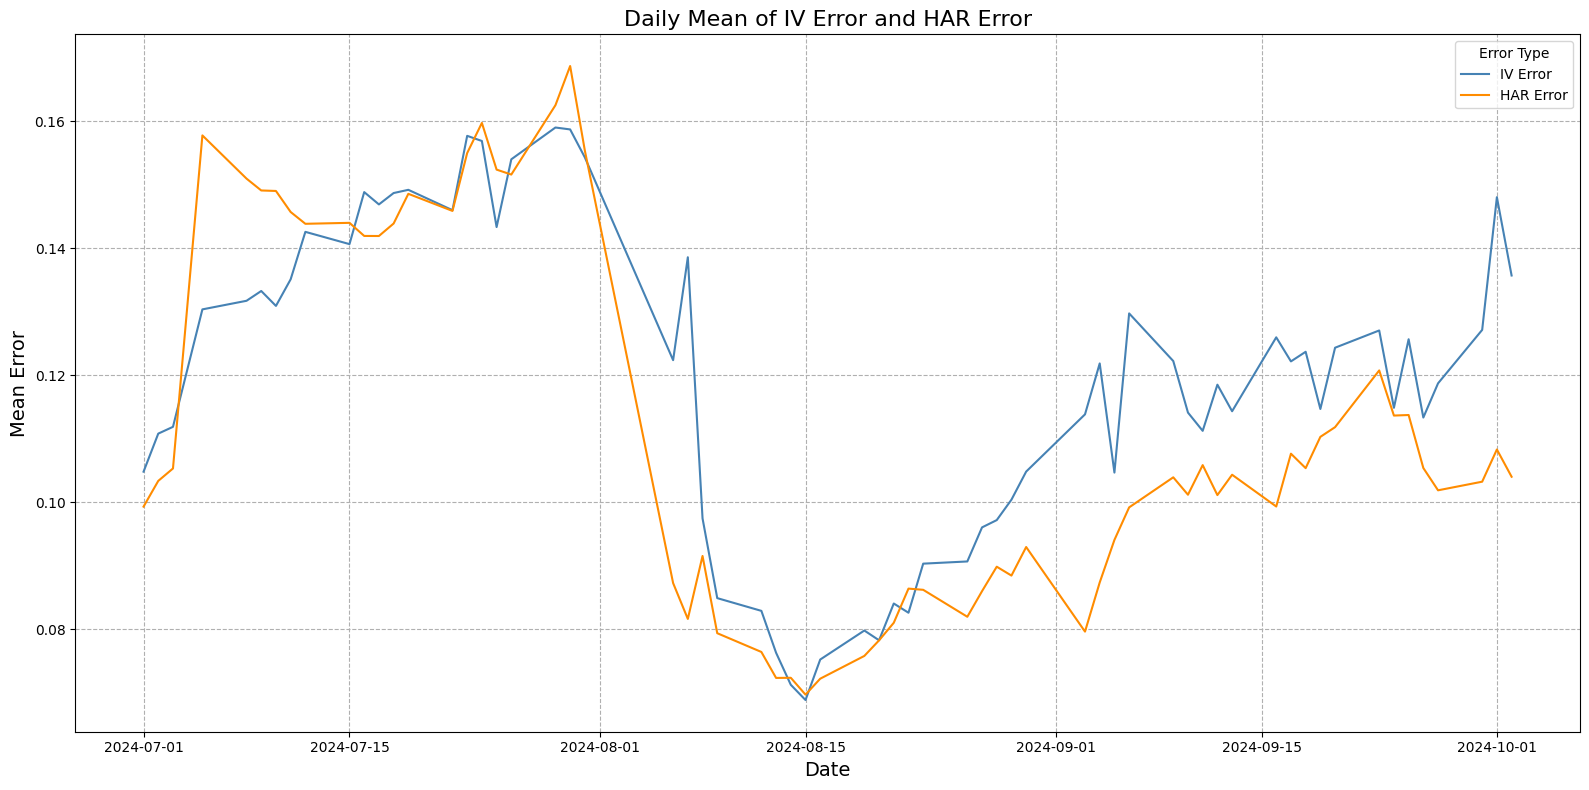

In [100]:
daily_error_df = resultsComparison.reset_index().groupby('Date', as_index=False).agg(
    iv_error_mean=('IV Error', 'mean'),
    har_error_mean=('HAR Error', 'mean')
)

# Set up the plot
plt.figure(figsize=(16, 8))

# Plot the time series for IV Error and HAR Error
plt.plot(daily_error_df['Date'], daily_error_df['iv_error_mean'], label='IV Error', color='steelblue')
plt.plot(daily_error_df['Date'], daily_error_df['har_error_mean'], label='HAR Error', color='darkorange')

# Set the title and labels
plt.title('Daily Mean of IV Error and HAR Error', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Mean Error', fontsize=14)

# Add a legend to differentiate IV Error and HAR Error
plt.legend(title='Error Type')

# Display the grid
plt.grid(True, linestyle='--')

# Show the plot
plt.tight_layout()
plt.show()

### Conclusion
While a small improvement in predictive accuracy was achieved, it is important to note that this analysis was conducted on a very limited dataset and over a short time period. As mentioned earlier, the primary objective of this project was not to develop a highly accurate predictive model, but rather to familiarize myself with handling option data and deriving insights from it. Developing a more robust model for predicting realised volatility would require a much more thorough analysis and could be a potential area for future exploration. With that said, this concludes my analysis of implied volatility in the most liquid U.S. equities.